In [1]:
#To understand spiking in Nengo

In [2]:
%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

In [3]:

# The lines/images should be input as a x by x image, not flattened
## Moves line in a continous direction, creates a label for that direction
def move_lines(lines, labels, randomDir = True, dir_amount = 30):

    #amount of timesteps it moves for, and creates "snapshots" from
    timesteps = 15

    #The two arrays that will get returned. Label and new "images/lines"
    dirs = np.zeros(lines.shape[0])
    moved_line = np.zeros([lines.shape[0],timesteps, lines.shape[1], lines.shape[2]])

    #For loop for each line that shall be moved
    for lnr, line in enumerate(lines,0):
        #Creates random direction for it to be moved in
        if randomDir == True:
            dir = np.random.randint(0,int(90/dir_amount))*dir_amount
        dirs[lnr] = dir

        # Finds original indexes for the line
        pos = np.where(line==1)
       
        pos = np.asarray(pos)
        pos = pos.astype(float)
        print(pos)
        #Creates first "image/line" in new array for first(zero) timestep
        moved_line[lnr, 0] = lines[lnr]
        #Goes through each timestep and moves positions of 1s / the line
        for x in range(timesteps-1):
            pos[0] = pos[0] + np.sin(dir*np.pi/180)
            pos[1] = pos[1] + np.cos(dir*np.pi/180)
            for xp, val in enumerate(pos[0],0):
                if int(pos[0][xp]) > -1 and int(pos[0][xp]) < 28 and int(pos[1][xp]) > -1 and int(pos[1][xp]) < 28:
                    moved_line[lnr, x, int(pos[0][xp]), int(pos[1][xp])] = 1

    return moved_line, dirs


In [4]:
import util as ut
ang_amount = 15
dir_amount = 15
lines, labels = ut.createLineX(28,28,800, ang_amount )

lines, directs = move_lines(lines, labels, dir_amount=dir_amount)
print(lines.shape)
print(directs.shape)
lines = lines.reshape((lines.shape[0], lines.shape[1], -1))
print(lines.shape)

## Angles separated by 3 
labels = labels/ang_amount 
labels = labels.astype(int)
lines = lines.astype(int)



[[ 7.  7.  8.  8.  9.  9. 10. 11. 11. 12. 12. 13. 13. 14. 15. 15. 16. 16.
  17. 17. 18. 18. 19. 19. 20. 20. 21.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
  19. 20. 20. 21. 22. 23. 24. 25. 26.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]
 [10. 10. 10. 11. 11. 11. 11. 12. 12. 12. 12. 13. 13. 13. 14. 14. 14. 15.
  15. 15. 15. 16. 16. 16. 16. 17. 17. 17.]]
[[ 7.  7.  8.  8.  9.  9. 10. 11. 11. 12. 12. 13. 13. 14. 15. 15. 16. 16.
  17. 17. 18. 18. 19. 19. 20. 20. 21.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
  19. 20. 20. 21. 22. 23. 24. 25. 26.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
  18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]
 [10. 10. 10. 11. 11. 11. 11. 12. 12. 12. 12. 13. 13. 13. 14. 14. 14. 15.
  15. 15. 15. 16. 16. 16. 16. 17. 17. 17.]]
[[ 7.  7.  8.  8.  9.  9. 10. 11. 11. 12. 12. 13. 13. 14. 15. 15. 16. 16.
  

In [5]:
a = np.array([[1,2,5],[3,7,6],[7,9,8]])

b = np.where(a == 7)
b = np.asarray(b)
b.astype(int)
#b.astype(int)
print((b[0])) # Second index value is which number you are looking at.
print(b[1])

[1 2]
[1 0]


In [6]:
print(lines[0:40].shape)
print(lines.shape)
train_images = lines[0:600]
test_images = lines[600:800]
print(test_images.shape)
print(train_images.shape)
train_labels = labels[0:600]
test_labels = labels[600:800]
print(test_labels.shape)
print(train_labels.shape)

(40, 15, 784)
(800, 15, 784)
(200, 15, 784)
(600, 15, 784)
(200,)
(600,)


In [7]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(
        inp, shape_in=(28, 28, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
        x, shape_in=(26, 26, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
        x, shape_in=(12, 12, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=90/ang_amount))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [8]:
minibatch_size = 20
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)


|###                   Building network (5%)                     | ETA: 0:00:02

F:\Python39\lib\site-packages\nengo_dl\simulator.py:460: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


In [9]:
#Not used right now
""" 
# add single timestep to training data
n_steps = 30
#train_images = train_images[:, None, :]
#train_labels = train_labels[:, None, None]
train_images = np.tile(train_images[:, None, :], (1, n_steps, 1))
train_labels = np.tile(train_labels[:, None, None], (1, n_steps, 1))


# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.

test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))
print(test_images.shape)
print(test_labels.shape) """

' \n# add single timestep to training data\nn_steps = 30\n#train_images = train_images[:, None, :]\n#train_labels = train_labels[:, None, None]\ntrain_images = np.tile(train_images[:, None, :], (1, n_steps, 1))\ntrain_labels = np.tile(train_labels[:, None, None], (1, n_steps, 1))\n\n\n# when testing our network with spiking neurons we will need to run it\n# over time, so we repeat the input/target data for a number of\n# timesteps.\n\ntest_images = np.tile(test_images[:, None, :], (1, n_steps, 1))\ntest_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))\nprint(test_images.shape)\nprint(test_labels.shape) '

In [10]:


# add single timestep to training data
n_steps = 15
#train_images = train_images[:, None, :]
#train_labels = train_labels[:, None, None]
#train_images = np.tile(train_images[:, None, :], (1, n_steps, 1))
train_labels = np.tile(train_labels[:, None, None], (1, n_steps, 1))


# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.

#test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))
#print(test_images.shape)
print(test_labels.shape)

(200, 15, 1)


In [11]:
""" moved_line = np.zeros([test_images.shape[0], 15, test_images.shape[1]])
print(moved_line.shape)
b = test_images.reshape(40,30,28,28)
print(b.shape) """

' moved_line = np.zeros([test_images.shape[0], 15, test_images.shape[1]])\nprint(moved_line.shape)\nb = test_images.reshape(40,30,28,28)\nprint(b.shape) '

In [12]:
def spikifyInput(input):
    r_sample = np.zeros(input.shape)
    for x, sample in enumerate(input):
        for y, timesample in enumerate(sample):
            for z, value in enumerate(timesample):
                if value == 1:
                    r_sample[x, y, z] = int(min(1,np.random.poisson(0.5)))
                        

    return r_sample

In [13]:
test_images = spikifyInput(test_images)
train_images = spikifyInput(train_images)

In [14]:
#print(spikifyInput(test_images)[11][3])

In [15]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])


# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy before training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Accuracy before training: 0.2150000035762787


In [16]:
do_training = True
if do_training:
    # run training
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )
    sim.fit(train_images, {out_p: train_labels}, epochs=25)

    # save the parameters to file
    sim.save_params("./mnist_params")
else:
    # download pretrained weights
    urlretrieve(
        "https://drive.google.com/uc?export=download&"
        "id=1l5aivQljFoXzPP5JVccdFXbOYRv3BCJR",
        "mnist_params.npz",
    )

    # load parameters
    sim.load_params("./mnist_params")

Epoch 1/25
30/30 [==============================] - 24s 750ms/step - loss: 1.7323 - out_p_loss: 1.7323
Epoch 2/25
30/30 [==============================] - 22s 747ms/step - loss: 1.3338 - out_p_loss: 1.3338
Epoch 3/25
30/30 [==============================] - 22s 746ms/step - loss: 1.1474 - out_p_loss: 1.1474
Epoch 4/25
30/30 [==============================] - 22s 745ms/step - loss: 1.0121 - out_p_loss: 1.0121
Epoch 5/25
30/30 [==============================] - 22s 746ms/step - loss: 0.9354 - out_p_loss: 0.9354
Epoch 6/25
30/30 [==============================] - 22s 747ms/step - loss: 0.8363 - out_p_loss: 0.8363
Epoch 7/25
30/30 [==============================] - 22s 745ms/step - loss: 0.7786 - out_p_loss: 0.7786
Epoch 8/25
30/30 [==============================] - 22s 747ms/step - loss: 0.6819 - out_p_loss: 0.6819
Epoch 9/25
30/30 [==============================] - 22s 747ms/step - loss: 0.5807 - out_p_loss: 0.5807
Epoch 10/25
30/30 [==============================] - 22s 747ms/step - los

In [17]:
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "Accuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
    
)

Accuracy after training: 0.9449999928474426


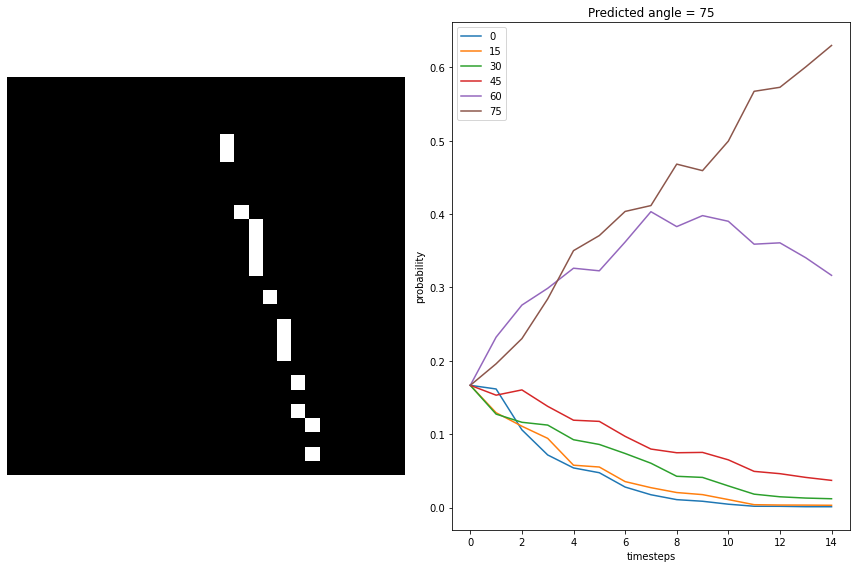

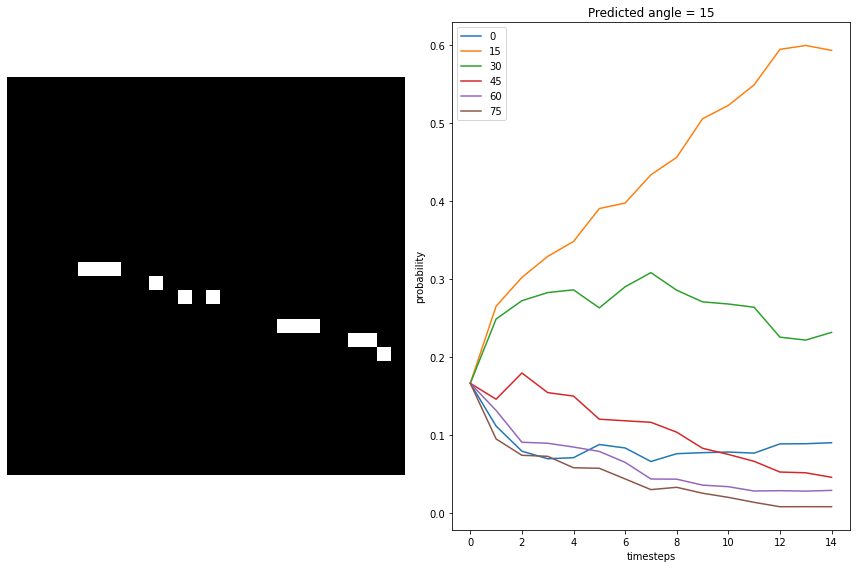

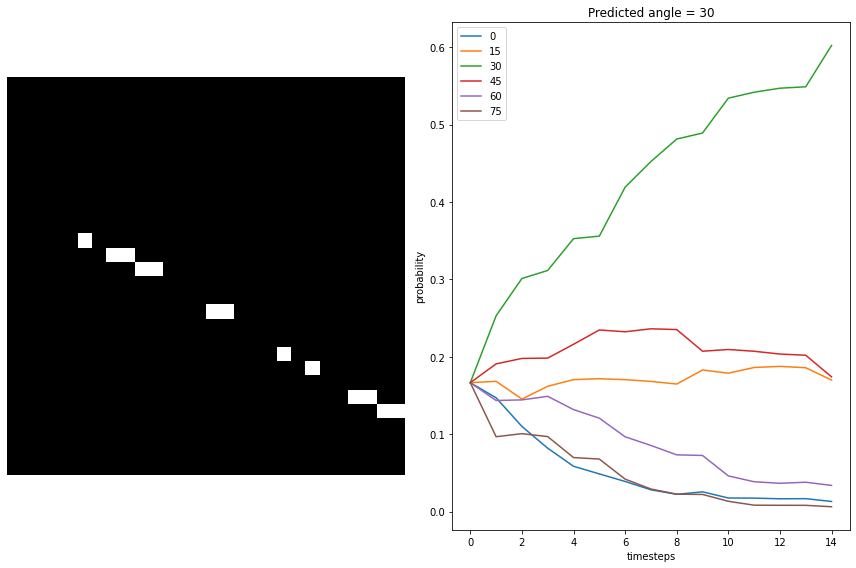

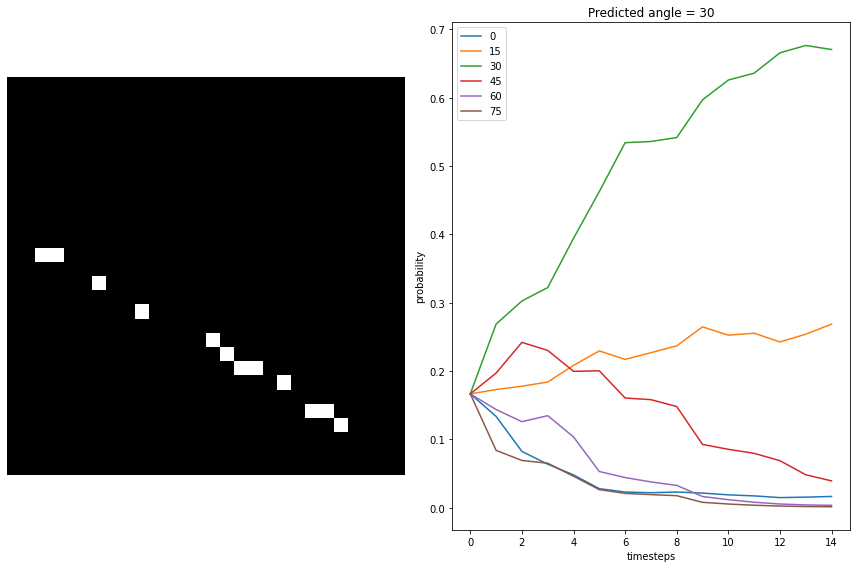

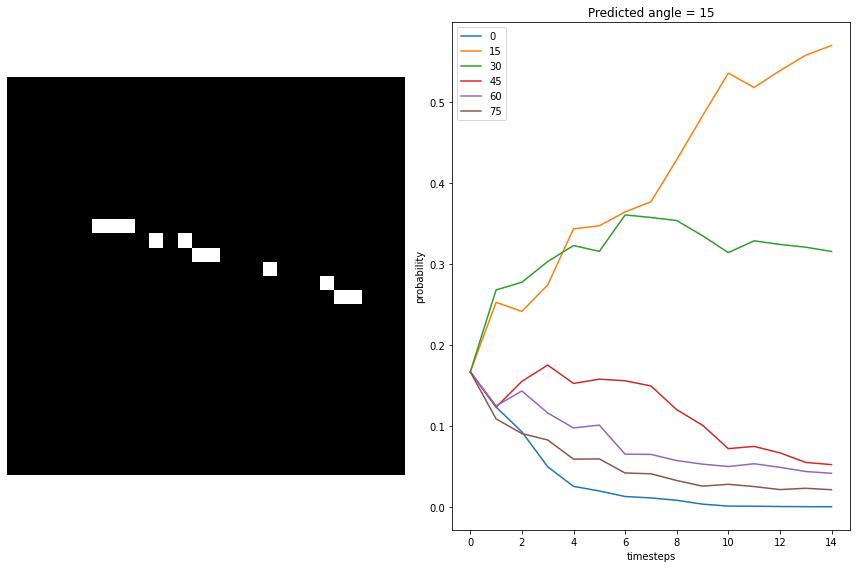

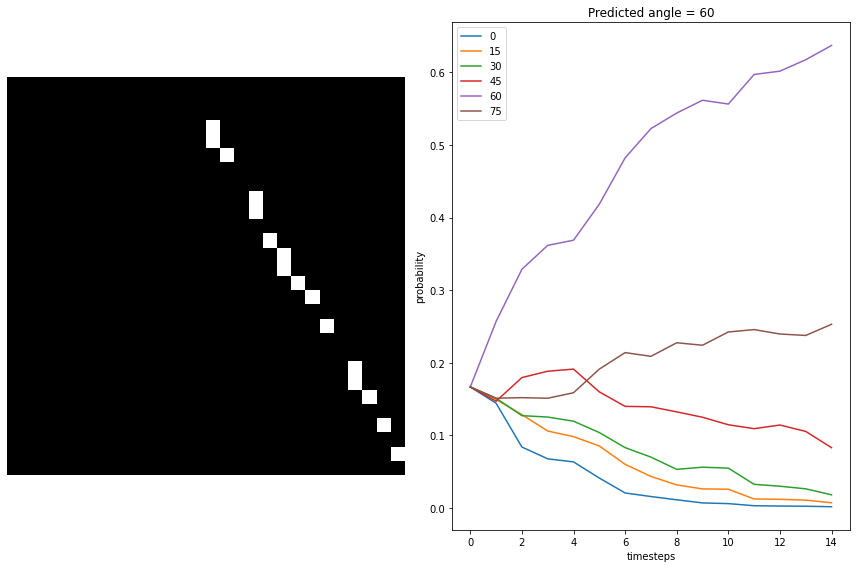

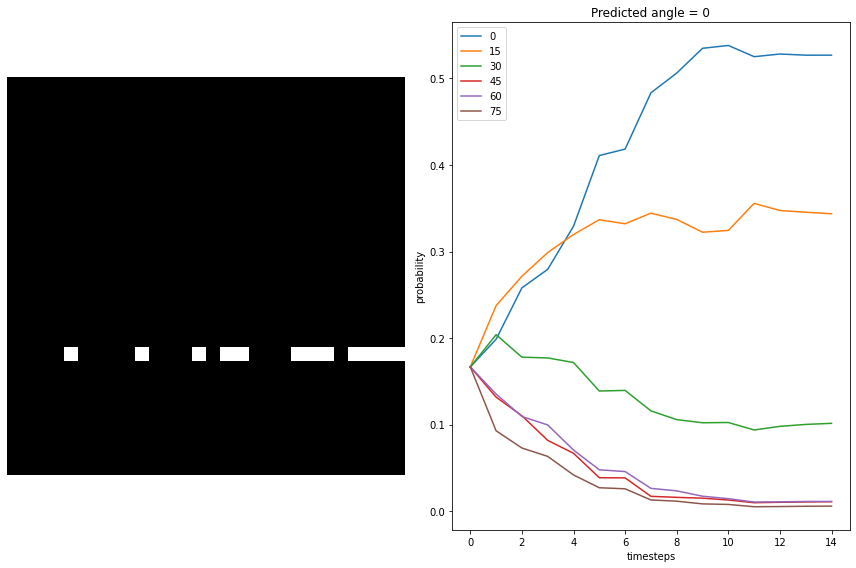

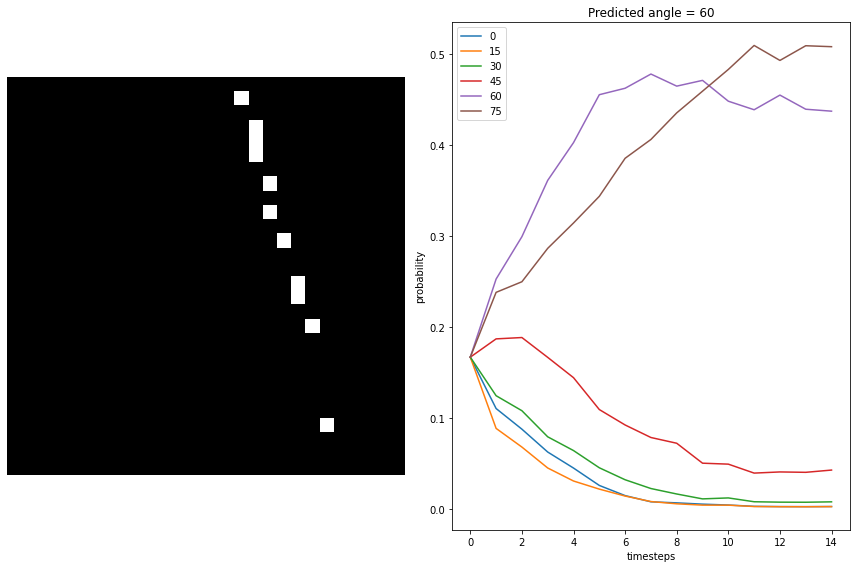

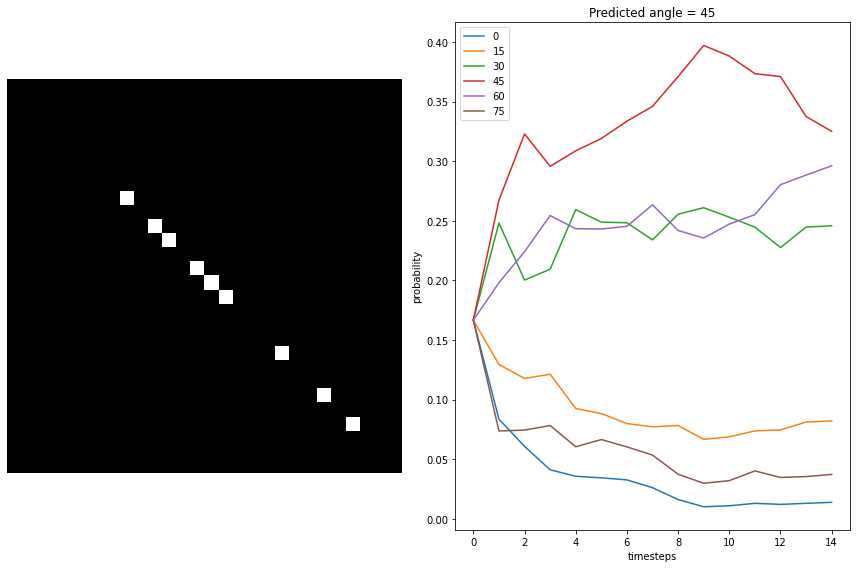

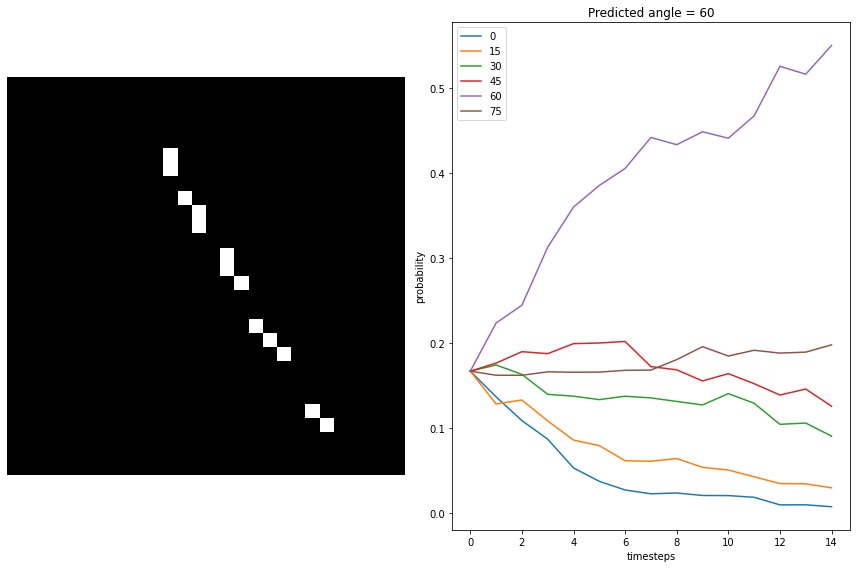

In [18]:
data = sim.predict(test_images[:minibatch_size])

for i in range(10):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 5].reshape((28, 28)), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    
    plt.plot(tf.nn.softmax(data[out_p_filt][i]))
    pred_angle = np.argmax(tf.nn.softmax(data[out_p_filt][i])[tf.nn.softmax(data[out_p_filt][i]).shape[1]-1]) * ang_amount
    plt.title("Predicted angle = {}".format(str(pred_angle)))
    plt.legend([str(i*ang_amount) for i in range(int(90/ang_amount))], loc="upper left")
    plt.xlabel("timesteps")
    plt.ylabel("probability")
    plt.tight_layout()